# Compare solver with station-based solver (YAN-1326)

The ska-sdp-func-python package has been updated with an ionospheric calibration solver that constrains low-order ionospheric phase shift variations across clusters of SKA-Low stations. The solver is an extension of an algorithm that has been used with MWA data for several years. It uses standard ska-sdp-datamodels data models, such as Visibilities and GainTables, as well as various other ska-sdp-func-python functions, and converts the solutions to station-based complex gains.

In previous notebooks the extended solver was shown to work on simulated data with complicated sky models (YAN-1288) and in a peel loop with closely separated calibration directions (YAN-1312). In this notebook the solver is compared with a station-based solver (defined in function station_solver). Rather than solving for phase shifts at a series of sub-bands across the bandwidth, the station-based solver assumes that the relative phase shifts are proportional to the observed wavelength and arise from variations in Total Electron Content (TEC) for different paths through the ionosphere. It is effectively an extreme case of the clustered ionospheric solver with a separate "cluster" for each station, and presumably has numerous similarities to the LEAP algorithm.

On the SKA-Low AA2 scales investigated in this notebook, the clustered solver is shown to produce more accurate phase solutions than the station-based solver for calibrators of a few hundred mJy or less, although the actual flux density cutoff is dependent on the solution intervals, the station clustering and the choice of basis functions. The flux limit for station-based solvers will also be higher for solvers that split the phase calibration process into sub-bands.

The benefit of the clustered solver is relatively modest as the array grows and has less clustering. Also, it is unclear how easily the solver could be worked into the phase screen optimisation approached used by team Schaap in the AA2 scaling tests, which alternates between direction-dependent and station-dependent solutions. Further work is needed to assess whether or not solutions from the clustered solver could be worked into that process.

There are benefits to clustering, though, and the size of the clusters and type of basis functions have not had much exploration. Also, the level of clustering could be tuned based on, for instance, the signal-to-noise ratio of a given calibrator or the state of the ionosphere. So an interesting comparison might be to use the new solver for both station-based and cluster-based calibration, and compare the resulting station-based phase screens with the alternative approach used in the AA2 scaling pipelines.

When SKA-Low cluster S16 is included in the simulations, the residuals for both algorithms can on occasion be contaminated by phase wraps. And the situation will be more common for more active ionospheres and lower frequencies. These can be solver errors, but can also come simply from different phase wrapping when subtracting true phases. It should be possible to mitigate the solver errors by first running direction-independent calibration for the field, using iteration-based solver weighting, including more station clusters near S16 (it is quite remote), etc., but this is not explored in this notebook.

Ionospheric phase shifts are generated via interpolation of a regular 2D grid of pierce points. The severity of the turbulent ionosphere can most easily be modified by changing the structure function diffractive scale, r_0. The expected covariance of baselines separated by r_0 is 1 rad^2, with large r_0 values reducing the amplitude of ionospheric phase shifts.

### Import packages and initialise sky, array and calibration models

For these comparisons a single, unresolved sky component will be used as the calibrator. To investigate the relative performance of the solvers for different signal-to-noise ratios, the calibrator will be simulated multiple times with a varying flux density.

In [1]:
"""Package imports"""

from matplotlib.pyplot import *
from matplotlib.offsetbox import AnchoredText
from scipy.interpolate import interp1d
import numpy

from astropy.coordinates import SkyCoord
from astropy import constants as const
from astropy import units
from ska_sdp_datamodels.calibration.calibration_create import (
    create_gaintable_from_visibility,
)
from ska_sdp_datamodels.calibration.calibration_model import GainTable
from ska_sdp_datamodels.configuration.config_coordinate_support import (
    hadec_to_azel,
)
from ska_sdp_datamodels.configuration.config_create import (
    create_named_configuration
)
from ska_sdp_datamodels.visibility.vis_create import create_visibility
from ska_sdp_datamodels.visibility.vis_model import Visibility
from ska_sdp_datamodels.science_data_model import PolarisationFrame
from ska_sdp_datamodels.sky_model import SkyComponent

from ska_sdp_func_python.imaging.dft import dft_skycomponent_visibility
from ska_sdp_func_python.calibration.ionosphere_solvers import (
    solve_ionosphere,
)
from ska_sdp_func_python.calibration.ionosphere_utils import (
    decompose_phasescreen,
    displace_phasescreen,
    interpolate_phasescreen,
)

import logging

logging.root.setLevel(logging.WARN)
logging.basicConfig()
log = logging.getLogger("yan-1326")


# Generate an array comprising core stations and four six-station clusters
# Start with a full array and then downselect to the desired sub-array
low_config = create_named_configuration("LOWBD2")

# Select the same core stations as AA2 but less distant clusters to keep plot
# easier to inspect
n_stations = low_config.stations.shape[0]
n_core = 40
AA2 = numpy.array([
    4, 8, 16, 17, 22, 23, 30, 31, 32, 33, 36, 52, 56, 57, 59,
    62, 66, 69, 70, 72, 73, 78, 80, 88, 89, 90, 91, 98, 108,
    111, 132, 144, 146, 158, 165, 167, 176, 183, 193, 200,  # C
    279, 280, 281, 282, 283, 284,  # S2
    285, 286, 287, 288, 289, 290,  # S3
    291, 292, 293, 294, 295, 296,  # S4
    327, 328, 329, 330, 331, 332,  # S5
    # 345, 346, 347, 348, 349, 350,  # S8
    # 351, 352, 353, 354, 355, 356,  # S9
    # 429, 430, 431, 432, 433, 434,  # S10
    # 435, 436, 437, 438, 439, 440,  # S11
    # 465, 466, 467, 468, 469, 470,  # S16
]) - 1
# Do the downselection
mask = numpy.isin(low_config.id.data, AA2)
low_config = low_config.sel(indexers={"id":numpy.arange(n_stations)[mask]})
# Reset station indices
n_stations = low_config.stations.shape[0]
low_config.stations.data = numpy.arange(n_stations).astype("str")
low_config = low_config.assign_coords(id=numpy.arange(n_stations))

# Create a vector with a cluster index for each station: one large cluster
# for core stations and six-station clusters for the rest
cluster_id = numpy.zeros(n_stations,"int")
cluster_id[n_core : n_stations] = (
    numpy.arange(n_stations - n_core).astype("int") // 6 + 1
)

# Generate a visibility container with one time step but multiple channels

# Set the phase centre in the ICRS coordinate frame
ra0 = 0.0 * units.hourangle
dec0 = -27.0 * units.deg
phase_centre = SkyCoord(ra=ra0, dec=dec0)

# Set LST in hours and convert to radians
times = numpy.array([1.0]) * numpy.pi / 12.0
chanwidth = 25e6
frequency = numpy.arange(100e6 + chanwidth / 2.0, 250e6, chanwidth)

emptyvis = create_visibility(
    low_config,
    times,
    frequency,
    channel_bandwidth=[chanwidth] * len(frequency),
    polarisation_frame=PolarisationFrame("stokesI"),
    phasecentre=phase_centre,
    weight=1.0,
)

# Set up parameters of independent Gaussian noise for each visibility sample
sample_time = 10.0
noise_mean = 0.0
# Generate the expected System Equivalent Flux Density, using the
# calculator from Sokolowski et al. 2022, PASA 39
# This is based on an AAVS2-like station pointing in the EoR0 direction. For
# more general solution, the python calculator should be installed and used.
# Noise generated for a field centred at 00 hrs, -27 deg
#  - AAVS2_sensitivity_ra0.00deg_dec_-27.00deg_0.00hours.txt
sim_freq = numpy.array([ 49.9200, 58.8800, 69.1200, 79.3600, 88.3200, 89.6000,99.8400,108.8000,119.0400,129.2800,139.5200,149.7600,154.8800,160.0000,168.9600,179.2000,185.6000,189.4400,199.6800,209.9200,216.3200,218.8800,229.1200,239.3600,249.6000,259.8400,268.8000,279.0400,289.2800,299.5200,309.7600,320.0000,328.9600,339.2000,349.4400])*1e6
sim_SEFDx = numpy.array([13689.163633,7169.768826,4921.713109,3626.448191,2925.419111,2846.024594,2371.964004,2155.226369,2025.520665,1914.953382,1827.958458,1818.613829,1872.251517,1940.699453,2012.247193,2120.719450,2123.762506,2092.097418,2047.851280,2044.712165,2135.363790,2146.222747,2270.385284,2375.922607,2246.154656,2205.609032,2084.623682,2197.201073,2352.864934,2420.103399,2423.814590,2249.786784,2244.833808,2371.012048,2586.549120])
sim_SEFDy = numpy.array([13706.670595,7225.702515,4939.329376,3643.092269,2936.531094,2855.105772,2373.570152,2162.044465,2100.491293,2052.820744,1958.236742,1998.655397,1977.974041,2078.091533,2257.589304,2390.946732,2376.884877,2347.302348,2236.785787,2225.573430,2289.971319,2268.919266,2410.668129,2500.411798,2384.011904,2219.641219,2145.307540,2225.426891,2414.252719,2545.779456,2593.632458,2441.535962,2405.695516,2571.120332,2729.272216])

# this matches the calculator output, which is equivalent to I = (XX + YY) / 2
#  - so using sim_SEFDx and/or sim_SEFDy in the Jones matrices is consistent
#    with setting YY=XX=I
sim_SEFDi = numpy.sqrt(sim_SEFDx**2 + sim_SEFDy**2) / 2
SEFD_fit = interp1d(sim_freq, sim_SEFDi, kind='cubic')
noise_std = SEFD_fit(frequency) / numpy.sqrt(chanwidth*sample_time)

print(f"Noise range: {numpy.min(noise_std):4.2f} - {numpy.max(noise_std):4.2f} Jy")

"""Determine pierce points: coordinates through the ionospheric phase
screen for a vector from each sky component to each station."""

# Set the parameters of sky model components
#  - for these tests, just repeat the same calibrator with varying flux density

alpha_f0 = 200e6

I0 = 10.0**numpy.arange(-3.0,0.2,0.1)
Iplot = 10.0**numpy.array([-3.0, -2.0, -1.0, 0.0])

n_calibrators = len(I0)

ra = 0.0 * numpy.ones(n_calibrators) * units.deg
dec = -27.0 * numpy.ones(n_calibrators) * units.deg
alpha = numpy.zeros(n_calibrators)

# Now calculate the pierce point for each station

x_stn = low_config.xyz.data[:, 0]
y_stn = low_config.xyz.data[:, 1]

x_pp = x_stn.copy()
y_pp = y_stn.copy()

# centre the cluster of pierce points at zero
x_pp -= (numpy.amax(x_pp) + numpy.amin(x_pp)) / 2
y_pp -= (numpy.amax(y_pp) + numpy.amin(y_pp)) / 2

"""Generate a regular 2D phase screen for all of the pierce points"""

# Set parameters for the final, high resolution phase screen
#  - resolution of screen (metres)
res = 7.0
#  - width of screen (metres). Here it is square but it could be rectangular
screen_width = 1.001 * max(
    numpy.amax(x_pp) - numpy.amin(x_pp),
    numpy.amax(y_pp) - numpy.amin(y_pp),
)

# Generate a coarse Nside x Nside grid of ionospheric phase shifts with
# Kolmogorov turbulence

# Width of the coarse screen (pixels)
Nside0 = 21

# Will successively halve the resolution n_interp times, so figure out what
# n_interp and the initial coarse resolution need to be
res0_min = screen_width / (Nside0 - 1)
n_interp = numpy.ceil(numpy.log2(res0_min / res)).astype("int")
res0 = res * 2 ** n_interp

# Coordaintes of the coarse grid
x = numpy.arange(Nside0) * res0
y = numpy.arange(Nside0) * res0
xx, yy = numpy.meshgrid(x, y)

# Decompose the convariance matrix of pierce point phase shifts obeying
# the ionospheric structure function at some nominal frequency
screen_f0 = 150e6
h_iono = 300e3      # Height of the screen in metres
r_0 = 20e3          #  structure function diffractive scale at screen_f0
beta = 5.0 / 3.0    #  structure function exponent
[evec_matrix, sqrt_evals] = decompose_phasescreen(xx, yy, r_0, beta)
n_points = xx.size

Noise range: 0.09 - 0.11 Jy


### Define a new solver for station-based calibration

This solver is like typical ANTSOL algorithms, but it is phase-only and includes a weighted average in frequency. It is effectively a station-based version of solve_ionosphere, and may be quite similar to LEAP. The relative phase shifts are assumed to be proportional to the observed wavelength and to arise from variations in Total Electron Content (TEC) for different paths through the ionosphere.

In [2]:
def rms(x):
    return numpy.sqrt(numpy.mean(numpy.abs(x)**2))


def station_solver(
    vis: Visibility,
    modelvis: Visibility,
    niter=15,
) -> GainTable:

    # Create a new gain table
    gain_table = create_gaintable_from_visibility(vis, jones_type="B")

    time = 0
    pol = 0

    for it in range(niter):

        # Set up storage for sums of visibility products for each station
        VM = numpy.zeros(n_stations)
        MM = numpy.zeros(n_stations)

        # Sum over each station and accumulate sums of visibility products
        for stn in range(n_stations):

            # Sums for the first station in each baseline:
            mask = (vis.antenna1.data == stn)
            VM[stn] = numpy.sum(numpy.einsum(
                "sf,f->s",
                numpy.imag(
                    vis.vis.data[time, mask, :, pol]
                    * numpy.conj(modelvis.vis.data[time, mask, :, pol])
                ),
                2.0 * numpy.pi * wl,
            ))
            MM[stn] = numpy.sum(numpy.einsum(
                "sf,f->s",
                numpy.real(
                    modelvis.vis.data[time, mask, :, pol]
                    * numpy.conj(modelvis.vis.data[time, mask, :, pol])
                ),
                (2.0 * numpy.pi * wl)**2,
            ))

            # Sums for the second station in each baseline:
            mask = (vis.antenna2.data == stn)
            VM[stn] -= numpy.sum(numpy.einsum(
                "sf,f->s",
                numpy.imag(
                    vis.vis.data[time, mask, :, pol]
                    * numpy.conj(modelvis.vis.data[time, mask, :, pol])
                ),
                2.0 * numpy.pi * wl,
            ))
            MM[stn] += numpy.sum(numpy.einsum(
                "sf,f->s",
                numpy.real(
                    modelvis.vis.data[time, mask, :, pol]
                    * numpy.conj(modelvis.vis.data[time, mask, :, pol])
                ),
                (2.0 * numpy.pi * wl)**2,
            ))

        # Gain updates
        soln = VM / (MM + (MM == 0))

        # Update the gain table
        gain_table.gain.data[time, :, :, pol, pol] *= numpy.exp(
            1j * 2.0 * numpy.pi * numpy.einsum("s,f->sf", soln, wl)
        )

        # Update the model
        modelvis.vis.data[time, :, :, pol] *= numpy.exp(
            1j * 2.0 * numpy.pi * numpy.einsum(
                "s,f->sf", soln[vis.antenna1.data] - soln[vis.antenna2.data],
                wl,
            )
        )

    # Return the gain table
    return gain_table

### Run solvers and generate simple error statistics

The solver is run n_run times with independent random phase screens. In the figures below, errors as a function calibrator flux density are show in the top left panel, and the errors averaged over the runs are shown in the top right panel. For the right-hand plots the flux density is converted to signal-to-noise ratio, I/sigma, after averging across the full bandwidth. In the lower panels the ratio of errors for the two solvers is shown: station-solver RMS error / clustered-solver RMS error. There are two sets of panels shown: errors calculated from gains and errors calculated from visibilities. For larger arrays than can experience phase-wrap errors, some effects cancel in the visibility plots.

The clustered solver is giving lower errors at moderate SNR values (cyan curves), but reaches a limit as model errors start to dominate over noise errors. The station-based solver can model the higher-order phase variations that are beyond the clustered-solver's basis functions, and its errors continue to drop as SNR increases (magenta curves).

The effects are shown in more detail in the final series of panels, where phase inputs, fits and errors are shown for each station and various SNR values. The top set of these panels shows a low SNR case where the fitted phase shifts jump around between +/- 180 degrees. Going down the rows, the SNR increases and the solutions improve, starting with the clustered solver. At the end where the SNR is high, the station-based solver is giving lower errors.

Run 0 of 5
Run 1 of 5
Run 2 of 5
Run 3 of 5
Run 4 of 5


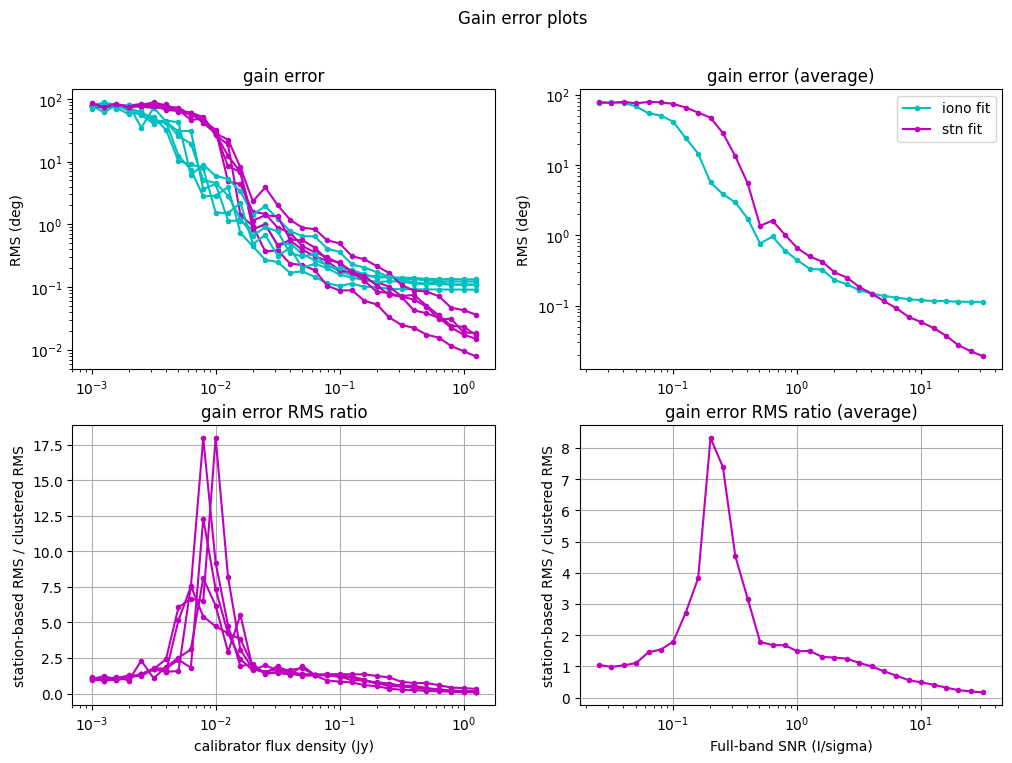

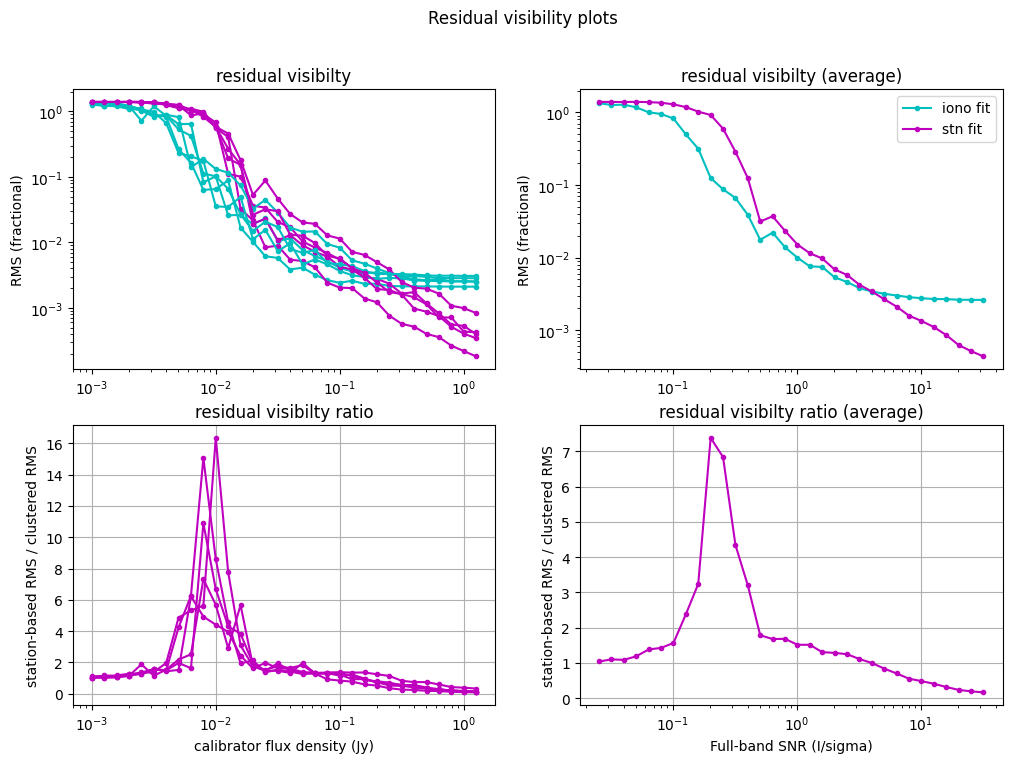

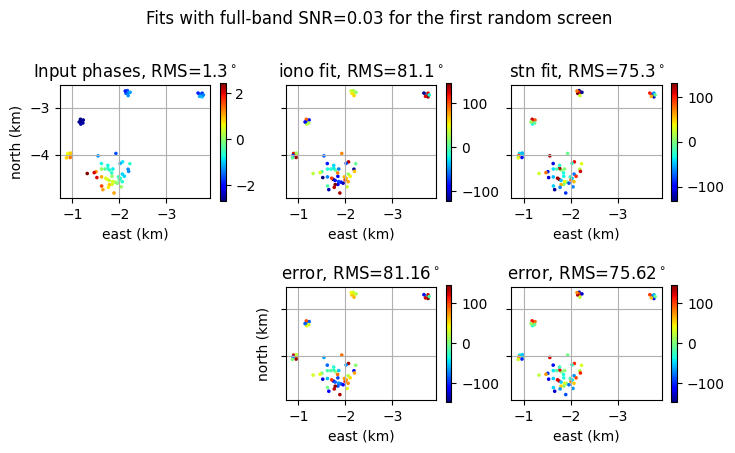

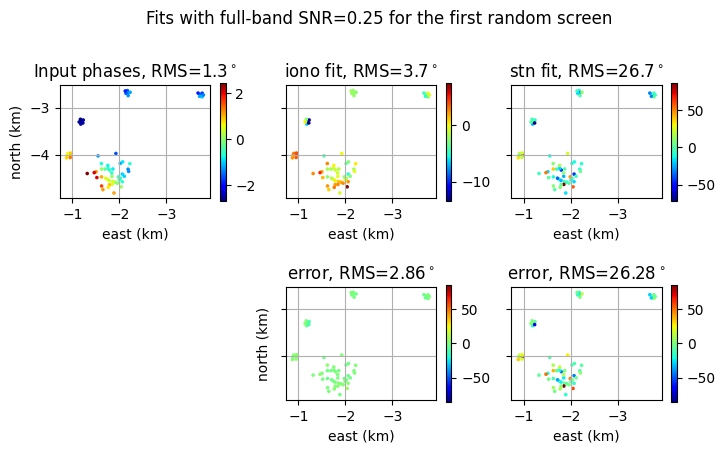

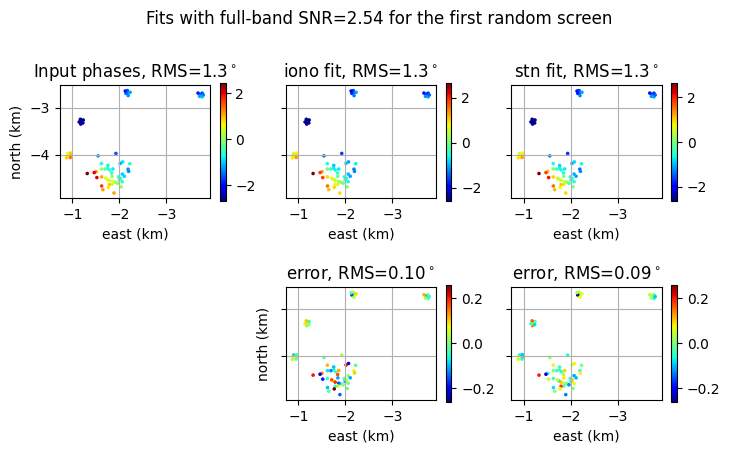

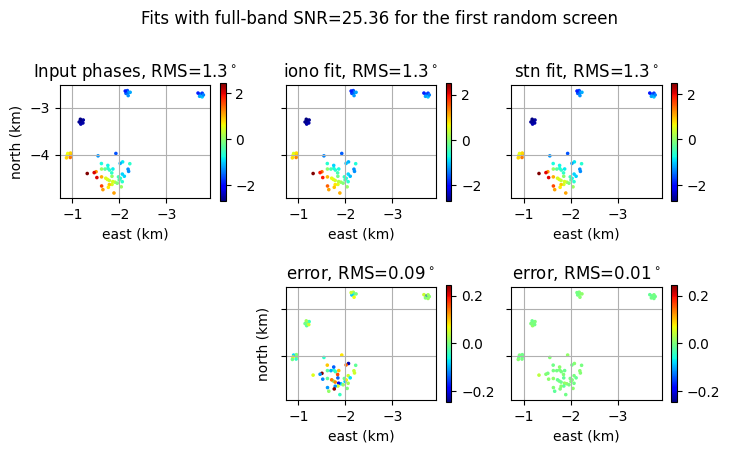

In [4]:
f1 = figure(num=1, figsize=(12,8), facecolor='w', edgecolor='k')
f1.suptitle("Gain error plots")
cmap = colormaps["jet"]
f1ca221 = subplot(221)
f1ca221.set_xscale('log')
f1ca221.set_yscale('log')
f1ca221.set_title("gain error")
f1ca221.set_ylabel("RMS (deg)")
f1ca222 = subplot(222)
f1ca222.set_xscale('log')
f1ca222.set_yscale('log')
f1ca222.set_title("gain error (average)")
f1ca222.set_ylabel("RMS (deg)")
f1ca223 = subplot(223)
f1ca223.set_xscale('log')
f1ca223.set_title("gain error RMS ratio")
f1ca223.set_xlabel("calibrator flux density (Jy)")
f1ca223.set_ylabel("station-based RMS / clustered RMS")
f1ca223.grid(True)
f1ca224 = subplot(224)
f1ca224.set_xscale('log')
f1ca224.set_title("gain error RMS ratio (average)")
f1ca224.set_xlabel("full-band SNR (I/sigma)")
f1ca224.set_ylabel("station-based RMS / clustered RMS")
f1ca224.grid(True)

f2 = figure(num=2, figsize=(12,8), facecolor='w', edgecolor='k')
f2.suptitle("Residual visibility plots")
cmap = colormaps["jet"]
f2ca221 = subplot(221)
f2ca221.set_xscale('log')
f2ca221.set_yscale('log')
f2ca221.set_title("residual visibilty")
f2ca221.set_ylabel("RMS (fractional)")
f2ca222 = subplot(222)
f2ca222.set_xscale('log')
f2ca222.set_yscale('log')
f2ca222.set_title("residual visibilty (average)")
f2ca222.set_ylabel("RMS (fractional)")
f2ca223 = subplot(223)
f2ca223.set_xscale('log')
f2ca223.set_title("residual visibilty ratio")
f2ca223.set_xlabel("calibrator flux density (Jy)")
f2ca223.set_ylabel("station-based RMS / clustered RMS")
f2ca223.grid(True)
f2ca224 = subplot(224)
f2ca224.set_xscale('log')
f2ca224.set_title("residual visibilty ratio (average)")
f2ca224.set_xlabel("full-band SNR (I/sigma)")
f2ca224.set_ylabel("station-based RMS / clustered RMS")
f2ca224.grid(True)

accum_fit_rms1 = numpy.zeros(n_calibrators)
accum_fit_rms2 = numpy.zeros(n_calibrators)
accum_vis_rms1 = numpy.zeros(n_calibrators)
accum_vis_rms2 = numpy.zeros(n_calibrators)

# Generate n_run random phase screens
n_run = 5
for run in range(n_run):

    print(f"Run {run} of {n_run}")

    # Generate a random realisation of the coarse phase screen
    screen0 = evec_matrix @ (sqrt_evals * numpy.random.randn(n_points))
    screen0 = screen0.reshape(xx.shape)

    Nside = Nside0
    res = res0
    screen = screen0.copy()
    for _ in range(n_interp):
        screen = interpolate_phasescreen(screen)
        screen = displace_phasescreen(screen, res, r_0, beta)
        Nside = 2 * Nside - 1
        res /= 2

    # Set phase screen constants and extract the phase shifts from the grid
    wl_scaling = screen_f0 / emptyvis.frequency.data
    i = ((x_pp + screen_width / 2) / res).astype("int")
    j = ((y_pp + screen_width / 2) / res).astype("int")
    pp_phase = screen[i, j]

    r2d = 180.0 / numpy.pi
    wl = const.c.value / emptyvis.frequency.data

    err_fit_rms1 = numpy.zeros(n_calibrators)
    err_fit_rms2 = numpy.zeros(n_calibrators)
    err_vis_rms1 = numpy.zeros(n_calibrators)
    err_vis_rms2 = numpy.zeros(n_calibrators)
    snr = numpy.zeros(n_calibrators)

    # Loop over the n_calibrators different calibrator flux densities
    for cal in range(n_calibrators):

        # Initialise the visibility data and model
        emptyvis.vis.data *= 0.0
        vis = emptyvis.copy(deep=True)
        modelvis1 = emptyvis.copy(deep=True)
        modelvis2 = emptyvis.copy(deep=True)

        # Predict this component into temporary storage
        # emptyvis data should be overwritten but set to zero anyway
        emptyvis.vis.data *= 0.0
        flux_density = I0[cal] * (frequency / alpha_f0) ** alpha[cal]
        tmpvis = dft_skycomponent_visibility(
            emptyvis,
            SkyComponent(
                direction=SkyCoord(ra=ra[cal], dec=dec[cal]),
                frequency=frequency,
                name=f"component-{cal}",
                flux=flux_density[:, numpy.newaxis],  # add the pol axis
                polarisation_frame=PolarisationFrame("stokesI"),
            ),
        )

        # Calculate visibility phase shift
        vis_phase = (
            pp_phase[vis.antenna1.data] - pp_phase[vis.antenna2.data]
        )
        # Add predicted visibilities to the main arrays
        #  - need to handle time and polarisation better than this...
        time = 0
        pol = 0
        modelvis1.vis.data += tmpvis.vis.data
        modelvis2.vis.data += tmpvis.vis.data
        vis.vis.data[time, :, :, pol] += (
            tmpvis.vis.data[time, :, :, pol] * numpy.exp(
                1j * numpy.einsum("b,f->bf", vis_phase, wl_scaling)
            )
        )

        # Add some noise
        noiseless = vis.copy(deep=True)
        for chan in range(len(frequency)):
            vis.vis.data[:, :, chan, :] += numpy.random.normal(
                noise_mean,
                noise_std[chan],
                vis.vis[:, :, chan, :].shape
            )

        # Estimate the full SNR across the total bandwidth
        snr[cal] = numpy.sum(flux_density) / numpy.sqrt(numpy.sum(noise_std**2))

        # Run the cluster-based ionospheric solver
        gain_table1 = solve_ionosphere(
            vis,
            modelvis1,
            low_config.xyz.data,
            cluster_id,
        )

        # Run the station-based solver
        gain_table2 = station_solver(
            vis,
            modelvis2,
        )

        # Get the fitted phase shifts, scaled to the screen frequency
        chan = 0
        time = 0
        pol = 0
        fit1 = (
            numpy.angle(gain_table1.gain.data[time, :, chan, pol, pol])
            / wl_scaling[0]
        )
        fit2 = (
            numpy.angle(gain_table2.gain.data[time, :, chan, pol, pol])
            / wl_scaling[0]
        )
        # Phase referencing against a single station:
        # ptrue = true_phase - true_phase[0]
        # pfit1 = fit1 - fit1[0]
        # pfit2 = fit2 - fit2[0]
        # or against all of the core stations:
        ptrue = pp_phase - numpy.mean(pp_phase[cluster_id==0])
        pfit1 = fit1 - numpy.mean(fit1[cluster_id==0])
        pfit2 = fit2 - numpy.mean(fit2[cluster_id==0])

        err1 = (numpy.array(pfit1.flatten() - ptrue.flatten()).flatten()) * r2d
        err2 = (numpy.array(pfit2.flatten() - ptrue.flatten()).flatten()) * r2d
        err_max = max(numpy.amax(numpy.abs(err1)), numpy.amax(numpy.abs(err2)))

        err_fit_rms1[cal] = rms(err1)
        err_fit_rms2[cal] = rms(err2)

        err_vis_rms1[cal] = rms(
            modelvis1.vis.data[0,:,:,0] - noiseless.vis.data[0,:,:,0]
        ) / I0[cal]
        err_vis_rms2[cal] = rms(
            modelvis2.vis.data[0,:,:,0] - noiseless.vis.data[0,:,:,0]
        ) / I0[cal]

        accum_fit_rms1[cal] += err_fit_rms1[cal] / n_run
        accum_fit_rms2[cal] += err_fit_rms2[cal] / n_run
        accum_vis_rms1[cal] += err_vis_rms1[cal] / n_run
        accum_vis_rms2[cal] += err_vis_rms2[cal] / n_run

        # plot the phase for a few select values of I0[cal]

        testvec = numpy.where(numpy.abs(Iplot - I0[cal])<1e-9)[0]
        if run > 0 or len(testvec) != 1:
            continue

        row = testvec[0]
        
        fig = figure()
        fig.suptitle(f"Fits with full-band SNR={snr[cal]:.2f} for the first random screen")
        subplots_adjust(left=0, right=1)

        aspect = "equal"
        # aspect = "auto"
        shrink = 0.7

        ca = subplot(231, aspect=aspect)
        phase = numpy.array(ptrue).flatten() * r2d
        c0a = numpy.amin(phase)
        c0b = numpy.amax(phase)
        scatter(x_stn/1e3, y_stn/1e3, c=phase, s=10, marker='.', \
            cmap=cmap, vmin=c0a, vmax=c0b
        )
        ca.invert_xaxis()
        title(rf"Input phases, RMS={rms(phase):.1f}$^\circ$")
        xlabel("east (km)")
        ylabel("north (km)")
        colorbar(shrink=shrink)
        grid()

        ca = subplot(232, aspect=aspect)
        ca.yaxis.set_ticklabels([])
        phase = numpy.array(pfit1).flatten() * r2d
        c0a = numpy.amin(phase)
        c0b = numpy.amax(phase)
        scatter(x_stn/1e3, y_stn/1e3, c=phase, s=10, marker='.', \
            cmap=cmap, vmin=c0a, vmax=c0b
        )
        ca.invert_xaxis()
        title(rf"iono fit, RMS={rms(phase):.1f}$^\circ$")
        xlabel("east (km)")
        colorbar(shrink=shrink)
        grid()

        ca = subplot(233, aspect=aspect)
        ca.yaxis.set_ticklabels([])
        phase = numpy.array(pfit2).flatten() * r2d
        c0a = numpy.amin(phase)
        c0b = numpy.amax(phase)
        scatter(x_stn/1e3, y_stn/1e3, c=phase, s=10, marker='.', \
            cmap=cmap, vmin=c0a, vmax=c0b
        )
        ca.invert_xaxis()
        title(rf"stn fit, RMS={rms(phase):.1f}$^\circ$")
        xlabel("east (km)")
        colorbar(shrink=shrink)
        grid()

        ca = subplot(235, aspect=aspect)
        ca.yaxis.set_ticklabels([])
        phase = numpy.array(pfit1.flatten() - ptrue.flatten()).flatten() * r2d
        c0a = -err_max
        c0b = +err_max
        scatter(x_stn/1e3, y_stn/1e3, c=phase, s=10, marker='.', \
            cmap=cmap, vmin=c0a, vmax=c0b
        )
        ca.invert_xaxis()
        title(rf"error, RMS={rms(phase):.2f}$^\circ$")
        xlabel("east (km)")
        ylabel("north (km)")
        colorbar(shrink=shrink)
        grid()

        ca = subplot(236, aspect=aspect)
        ca.yaxis.set_ticklabels([])
        phase = numpy.array(pfit2.flatten() - ptrue.flatten()).flatten() * r2d
        c0a = -err_max
        c0b = +err_max
        scatter(x_stn/1e3, y_stn/1e3, c=phase, s=10, marker='.', \
            cmap=cmap, vmin=c0a, vmax=c0b
        )
        ca.invert_xaxis()
        title(rf"error, RMS={rms(phase):.2f}$^\circ$")
        xlabel("east (km)")
        colorbar(shrink=shrink)
        grid()

    x_fn = I0

    f1ca221.plot(x_fn, err_fit_rms1, '.c-')
    f1ca221.plot(x_fn, err_fit_rms2, '.m-')
    f1ca223.plot(x_fn, err_fit_rms2/err_fit_rms1, '.m-')

    f2ca221.plot(x_fn, err_vis_rms1, '.c-')
    f2ca221.plot(x_fn, err_vis_rms2, '.m-')
    f2ca223.plot(x_fn, err_vis_rms2/err_vis_rms1, '.m-')

x_fn = snr

f1ca222.plot(x_fn, accum_fit_rms1, '.c-', label="iono fit")
f1ca222.plot(x_fn, accum_fit_rms2, '.m-', label="stn fit")
f1ca222.legend()
f1ca224.plot(x_fn, accum_fit_rms2/accum_fit_rms1, '.m-')

f2ca222.plot(x_fn, accum_vis_rms1, '.c-', label="iono fit")
f2ca222.plot(x_fn, accum_vis_rms2, '.m-', label="stn fit")
f2ca222.legend()
f2ca224.plot(x_fn, accum_vis_rms2/accum_vis_rms1, '.m-')